### Convert PCAPNG to PCAP
This code can be used to convert PCAPNG files to PCAP files.</br>
We need this conversion since the dpkg library (which processes PCAP files in a fast manner) only processes PCAP files.

You only have to install Wireshark (to be able to use tshark). Then, provide the directory of tshark in the "tshark_path" variable.</br>
Similarly, include all of your PCAPNG files in a directory, and then store the location of the directory in the "pcapng_directory_path" variable.

In [2]:
import os
import subprocess

def check_pcap_type(file_path):
    with open(file_path, 'rb') as file:
        header = file.read(4)
        if header in [b'\xd4\xc3\xb2\xa1', b'\xa1\xb2\xc3\xd4']:
            return "PCAP"
        elif header == b'\x0a\x0d\x0d\x0a':
            return "PCAPNG"
        return "Unknown format"

def rename_pcapng_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".pcap"):  # Only check files that are presumed to be pcap
            file_path = os.path.join(directory, filename)
            file_type = check_pcap_type(file_path)
            if file_type == "PCAPNG":
                new_file_name = filename[:-5] + ".pcapng"
                new_file_path = os.path.join(directory, new_file_name)
                os.rename(file_path, new_file_path)
                print(f"Renamed '{filename}' to '{new_file_name}'")

def convert_pcapng_to_pcap(directory, tshark_path):
    for filename in os.listdir(directory):
        if filename.endswith(".pcapng"):
            input_path = os.path.join(directory, filename)
            output_filename = filename[:-7] + ".pcap"
            output_path = os.path.join(directory, output_filename)
            cmd = [tshark_path, '-F', 'pcap', '-r', input_path, '-w', output_path]
            try:
                subprocess.run(cmd, check=True)
                print(f"Converted '{filename}' to '{output_filename}'")
            except subprocess.CalledProcessError as e:
                print(f"Failed to convert '{filename}': {e}")

# Set your directory path here
pcapng_directory_path = 'D:\\UCD\\Research Paper\\Dataset M-En\\trad_mal'

# Rename .pcap files to .pcapng if they are actually PCAPNG
rename_pcapng_files(pcapng_directory_path)

# Example usage with a specified path to tshark
tshark_path = 'C:\\Program Files\\Wireshark\\tshark' # '/usr/bin/tshark'  # Adjust this path based on your system
# Convert all .pcapng files to .pcap
convert_pcapng_to_pcap(pcapng_directory_path, tshark_path)

<pre>
Dataset 1:
rep: https://www.kaggle.com/datasets/alaaalatram/dosddos-mqtt-iot/
paper: https://www.sciencedirect.com/science/article/pii/S1389128623002542

Dataset 2:
https://research.unsw.edu.au/projects/toniot-datasets 

Dataset 3:
paper: https://www.scitepress.org/papers/2018/66398/66398.pdf
repo: https://www.unb.ca/cic/datasets/ids-2017.html

Dataset 4:
https://www.unb.ca/cic/datasets/ddos-2019.html
direct access: http://205.174.165.80/CICDataset/CICDDoS2019/Dataset/

Dataset 5:
https://www.unb.ca/cic/datasets/nsl.html

Survey:
https://www.sciencedirect.com/science/article/pii/S2542660523001038
</pre>

# 1. Basic Information Extraction

In [ ]:
!pip install --upgrade pip
!pip install dpkt pandas scikit-learn

In [ ]:
import os
import dpkt
import socket
import pandas as pd

# verify if the file is PCAP
# sometimes the file has a PCAP extention but it is stored as a PCAPNG file
def check_pcap_type(file_path):
    with open(file_path, 'rb') as file:
        header = file.read(4)
        if header == b'\xd4\xc3\xb2\xa1' or header == b'\xa1\xb2\xc3\xd4':
            return "PCAP"
        elif header == b'\x0a\x0d\x0d\x0a':
            return "PCAPNG"
        else:
            return "Unknown format"

def process_all_sub_directories(main_dir, subdirectories):
    # Initialize an empty DataFrame to store all the results
    combined_data = pd.DataFrame()

    # Enumerate through the subdirectories list to get both index and directory name
    for dir_index, subdir in enumerate(subdirectories):
        directory_path = os.path.join(main_dir, subdir)
        print(f"\nProcessing dir_index: {dir_index}, directory: {directory_path}")

        # Check if the directory exists before processing
        if os.path.exists(directory_path):
            df = process_one_directory(directory_path, dir_index)
            # Append the processed data of this directory to the combined DataFrame
            combined_data = pd.concat([combined_data, df], ignore_index=True)
            if not combined_data.empty:
                print(f"Completed processing {directory_path}. Data shape: {df.shape}")
        else:
            print(f"Directory {directory_path} does not exist")
    return combined_data

def process_one_directory(directory, dir_index):
    all_data = pd.DataFrame()
    for filename in os.listdir(directory):
        if filename.endswith('.pcap'):
            filepath = os.path.join(directory, filename)
            print(f"Processing {filepath}...")
            df = pcap_to_df(filepath, dir_index)
            all_data = pd.concat([all_data, df], ignore_index=True)
    return all_data

def pcap_to_df(pcap_dir, dir_index):

    # Check the file type first
    file_type = check_pcap_type(pcap_dir)

    # If the file type is not PCAP, abort the operation
    if file_type != "PCAP":
        print(f"Aborting operation: file {file_type}.")
        if file_type == "PCAPNG":
            print("conver the PCAPNG to PCAP using: tshark -F pcap -r input.pcapng -w output.pcap\n")
        return  # Stops the function execution here

    # Open the pcap file
    with open(pcap_dir, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
    
        data = []
    
        while True:
            try:
                timestamp, buf = next(pcap)
                try:                
                    eth = dpkt.ethernet.Ethernet(buf)
        
                    # Check for VLAN
                    if eth.type == 0x8100: # VLAN tag type
                        eth = dpkt.ethernet.Ethernet(eth.data)
        
                    if not isinstance(eth.data, dpkt.ip.IP):
                        continue  # Skip non-IPv4 packets
        
                    ip = eth.data
        
                    ip_src = socket.inet_ntoa(ip.src)
                    ip_dst = socket.inet_ntoa(ip.dst)
                    protocol = ip.p
                    ttl = ip.ttl
                    packet_size = len(buf) # Total length of the packet (including all headers and payload)
        
                    # Initialize as 0
                    ack_flag = syn_flag = fin_flag = psh_flag = urg_flag = rst_flag = 0
                    src_port = dst_port = sequence = acknowledgment = 0
                    udp_flag = tcp_flag = 0
                    payload_size = 0
                    label = 0
        
                    # Check for TCP
                    if ip.p == dpkt.ip.IP_PROTO_TCP and isinstance(ip.data, dpkt.tcp.TCP):
                        tcp = ip.data
                        ack_flag = 1 if (tcp.flags & dpkt.tcp.TH_ACK) else 0
                        syn_flag = 1 if (tcp.flags & dpkt.tcp.TH_SYN) else 0
                        fin_flag = 1 if (tcp.flags & dpkt.tcp.TH_FIN) else 0
                        psh_flag = 1 if (tcp.flags & dpkt.tcp.TH_PUSH) else 0
                        urg_flag = 1 if (tcp.flags & dpkt.tcp.TH_URG) else 0
                        rst_flag = 1 if (tcp.flags & dpkt.tcp.TH_RST) else 0
                        src_port = tcp.sport
                        dst_port = tcp.dport
                        sequence = tcp.seq
                        acknowledgment = tcp.ack
                        tcp_flag = 1
                        payload_size = ip.len - ip.hl * 4 - tcp.off * 4
    
                    # Check for UDP
                    elif ip.p == dpkt.ip.IP_PROTO_UDP and isinstance(ip.data, dpkt.udp.UDP):
                        udp = ip.data
                        src_port = udp.sport
                        dst_port = udp.dport
                        udp_flag = 1
                        payload_size = ip.len - ip.hl * 4 - 8  # 8 bytes for UDP header

                    if dir_index == 0:
                        # Create Label column: 1 (malicious) if src or dst port is 9, 0 (benign) otherwise
                        # label = 1 if src_port == 9 or dst_port == 9 else 0
                        if src_port == 9 or dst_port == 9:
                            # if ack_flag == 1 and syn_flag == 1:
                            #     print('Error')
                            if ack_flag == 1:
                                label = 1
                            elif syn_flag == 1:
                                label = 2
                            elif udp_flag == 1:
                                label = 3
                    elif dir_index == 1:
                        label = 4
                    elif dir_index == 2:
                        label = 5

                    data.append({
                        'Timestamp': timestamp,
                        'Source': ip_src,
                        'Destination': ip_dst,
                        'Protocol': protocol,
                        'SrcPort': src_port,
                        'DstPort': dst_port,
                        'TCP': tcp_flag,
                        'UDP': udp_flag,
                        'TTL': ttl,
                        'ACK': ack_flag,
                        'SYN': syn_flag,
                        'FIN': fin_flag,
                        'PSH': psh_flag,
                        'URG': urg_flag,
                        'RST': rst_flag,
                        'SequenceNumber': sequence,
                        'AcknowledgmentNumber': acknowledgment,
                        'PacketSize': packet_size,
                        'PayloadSize': payload_size,
                        'Label': label
                    })
                except Exception as e:
                        print(f"Error processing packet at timestamp {timestamp}: {e}")
                        continue  # Skip this problematic packet

            except StopIteration:
                break  # End of pcap file

            except dpkt.dpkt.NeedData as e:
                print(f"Truncated packet at timestamp {timestamp}: {e}")
                continue

            except Exception as e:
                print(f"Error processing packet: {e}")
                # Print the entire packet bytes (in hex format)
                # print(f"Packet Bytes: {buf.hex()}")
                continue  # Skip problematic packets

        # return the list as a DataFrame
        return pd.DataFrame(data)

In [ ]:
# get the current working directory
cwd = os.getcwd()

# List of subdirectories for pcap files
subdirectories = ["ddosim", "iot_B", "trad_mal"]

all_df = process_all_sub_directories (cwd, subdirectories)

# After processing all directories, print the shape of the combined DataFrame
if not all_df.empty: # Check if the DataFrame is empty
    print(f"\nTotal combined data shape: {all_df.shape}")
    print(all_df['Label'].value_counts())
else:
    print("DataFrame is empty")


Processing dir_index: 0, directory: D:\UCD\Research Paper\Dataset M-En\ddosim
Processing D:\UCD\Research Paper\Dataset M-En\ddosim\input.pcap...
Truncated packet at timestamp 699.632225: got 4, 16 needed at least
Completed processing D:\UCD\Research Paper\Dataset M-En\ddosim. Data shape: (5256519, 20)

Processing dir_index: 1, directory: D:\UCD\Research Paper\Dataset M-En\iot_B
Processing D:\UCD\Research Paper\Dataset M-En\iot_B\NormalData1.pcap...
Processing D:\UCD\Research Paper\Dataset M-En\iot_B\NormalData10.pcap...
Processing D:\UCD\Research Paper\Dataset M-En\iot_B\NormalData11.pcap...
Processing D:\UCD\Research Paper\Dataset M-En\iot_B\NormalData12.pcap...
Processing D:\UCD\Research Paper\Dataset M-En\iot_B\NormalData13.pcap...
Processing D:\UCD\Research Paper\Dataset M-En\iot_B\NormalData14.pcap...
Processing D:\UCD\Research Paper\Dataset M-En\iot_B\NormalData15.pcap...
Processing D:\UCD\Research Paper\Dataset M-En\iot_B\NormalData2.pcap...
Processing D:\UCD\Research Paper\Dat

In [ ]:
# Save to a CSV file
all_df.to_csv('extracted_data.csv', index=False)
print("\nProcessing complete. Saved to CSV file.")


Processing complete. Saved to CSV file.


# 2. Statistical Feature Extraction

In [ ]:
import pandas as pd
df = pd.read_csv('extracted_data.csv')
df.head()

,Timestamp,Source,Destination,Protocol,SrcPort,DstPort,TCP,UDP,TTL,ACK,SYN,FIN,PSH,URG,RST,SequenceNumber,AcknowledgmentNumber,PacketSize,PayloadSize,Label
0,0.382887,10.0.0.5,10.0.0.1,6,40718,1935,1,0,64,0,1,0,0,0,0,2163861465,0,78,0,0
1,0.382918,10.0.0.1,10.0.0.5,6,1935,40718,1,0,64,1,1,0,0,0,0,751195550,2163861466,78,0,0
2,0.382992,10.0.0.5,10.0.0.1,6,40718,1935,1,0,64,1,0,0,0,0,0,2163861466,751195551,70,0,0
3,0.383107,10.0.0.5,10.0.0.1,6,40718,1935,1,0,64,1,0,0,0,0,0,2163861466,751195551,1518,1448,0
4,0.383116,10.0.0.5,10.0.0.1,6,40718,1935,1,0,64,1,0,0,1,0,0,2163862914,751195551,159,89,0


### 2.1 Periodic Statistical Features

In the context of developing an Intrusion Detection System (IDS) for identifying Mirai botnet Distributed Denial of Service (DDoS) attacks such as ACK Flood, SYN Flood, and UDP Flood, the extraction of 24 statistical features from network packet data plays a pivotal role. Each feature provides unique insights into the traffic patterns and anomalies, thereby aiding in the effective detection of these attacks. Below is a description of how each feature is calculated and their rationale:



---

### Feature Descriptions for DDoS Traffic Detection


1. **Packet Counts**: This feature represents the total number of packets observed in each time window (group). In the context of DDoS attack detection, a sudden increase in the packet count can be a significant indicator of an attack. DDoS attacks like SYN Flood or UDP Flood often generate a large volume of packets in a short period, aiming to overwhelm the target system's resources. Monitoring the packet count helps in identifying such abnormal spikes in network traffic, which are characteristic of these types of attacks.

2. **Destination Port Entropy**: This feature is calculated by first counting the occurrences of each destination port (`DstPort`) in a time window, then determining the probability distribution of these ports, and finally calculating the entropy of this distribution. High entropy in destination ports may indicate scanning activity, a common precursor to DDoS attacks.

3. **Most Frequent Source Port**: Identifies the source port (`SrcPort`) that occurs most frequently within a window, if it exceeds a predefined threshold. In DDoS attacks, source ports might be spoofed or concentrated, and this feature helps in identifying such anomalies.

4. **Most Frequent Destination Port**: Similar to the most frequent source port, this feature identifies the most commonly targeted destination port. DDoS attacks often target specific ports on a host, making this a crucial feature for detection.

5. **Short-lived Connections**: Counts the number of connections that are short-lived, based on a predefined threshold on packet size. DDoS attacks often initiate numerous short-lived connections to overwhelm a target.

6. **Repeated Connection Attempts**: Measures the number of duplicated destination addresses within a group, indicative of repeated attempts to establish a connection, which can be a sign of an attack.

7. **Network Scanning Activity**: Counts instances where the SYN flag is set but the ACK flag is not, indicating a potential scanning activity, which is often a precursor to more aggressive attacks.

8. **Flow Rate**: Calculated as packets per second within each window, providing insight into the intensity of traffic, which can spike during DDoS attacks.

9. **Source Entropy**: Measures the entropy of source addresses within a window. High entropy might indicate spoofed or randomized sources, common in botnet behavior.

10. **Connection Errors (RST flag)**: Counts the instances of RST flag being set, indicating connection resets, which can be frequent in disrupted networks under DDoS attack.

11. **Most Frequent Packet Size Frequency**: Identifies the most commonly occurring packet size. DDoS attacks often use uniform packet sizes for flooding.

12. **Abnormal Size Frequency**: Counts packets that exceed a certain size threshold, useful for detecting payloads that are anomalously large, potentially indicative of certain types of attacks.

13. **Sequence Number Variance**: Measures the variance in sequence numbers of packets, as irregularities in this pattern can suggest spoofing or session hijacking attempts.

14. **Average Packet Number**: The average number of packets per defined processing interval. A sudden increase can indicate a flood attack.

15. **SYN Frequency**: The frequency of SYN flag occurrences, divided by the processing interval. Elevated levels can indicate SYN flood attacks.

16. **ACK Frequency**: Similar to SYN frequency, but for ACK flags. High frequencies can be indicative of ACK flood attacks.

17. **TCP Frequency**: The proportion of TCP packets within a window. Since many DDoS attacks exploit TCP protocols, this metric is vital.

18. **UDP Frequency**: The proportion of UDP packets, important for detecting UDP flood attacks.

19. **Most Frequent Protocol**: Identifies the most used protocol within a window. A sudden shift in protocol usage can signal an ongoing attack.

20. **Packet Size Variability**: The variance in packet sizes, as attacks often disrupt the normal distribution of packet sizes.

21. **Most Frequent Payload Size**: Detects the most common payload size within a window. Consistency in payload sizes can be a characteristic of automated attack tools.

22. **Average Payload Size**: The mean size of payloads, providing a baseline for detecting deviations typical in flood attacks.

22. **Packet Size Standard Deviation**: The standard deviation of packet sizes within each time window provides insights into the variability of packet sizes. In normal network traffic, packet sizes can vary but usually within a predictable range. However, during DDoS attacks, especially those employing large or irregularly sized packets (like certain UDP Flood attacks), this variability can increase significantly. High standard deviation in packet sizes during a short window can thus be a potential indicator of anomalous traffic patterns associated with DDoS attacks.

24. **Average Packet Size**: This feature calculates the mean size of packets within each time window. Mirai botnet attacks can sometimes be characterized by the uniformity of packet sizes, especially in scenarios where attackers use similar or identical packets to flood a network. Conversely, some attack vectors may use packets of varying sizes to evade detection. Therefore, the average packet size, when observed in conjunction with other features like packet count and variability, can provide valuable context. A notable deviation from the typical average packet size in a network could be indicative of an ongoing attack.

**Note**
The incorporation of a threshold in some of these features is crucial. It ensures the statistical significance of the calculated feature, mitigating the risk of false positives arising from random or evenly distributed usage of this feature in benign traffic. This threshold-based approach enhances the robustness of the features, thereby improving the overall accuracy and reliability of the IDS in detecting botnet DDoS attacks.

In essence, these features serve to capture different dimensions of the traffic profile within defined time windows. By analyzing them in tandem, an IDS can more effectively discern between normal network behavior and traffic patterns that are symptomatic of DDoS attacks. For instance, a combination of high packet counts, increased variability in packet sizes, and deviations in average packet size can collectively point towards the likelihood of a Mirai botnet DDoS attack. These statistical measures enable a nuanced approach to detecting and responding to such threats, enhancing the efficacy of the IDS in safeguarding network infrastructures.

---

### Importance in DDoS Detection

These features are designed to capture various aspects of network traffic that deviate from normal patterns and are characteristic of DDoS attacks. By analyzing these features over fixed time windows (e.g., every 20 seconds), it's possible to detect sudden changes in network behavior indicative of an attack. The use of time windows allows for near real-time detection, crucial for effective mitigation of DDoS attacks.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

df_tmp = df.copy()

# The time interval that we are using to aggregate our packets (measured in seconds)
processing_interval = 1

# Define a threshold for abnormal packet size (adjust based on your network)
abnormal_size_threshold = 1500  # threshold in bytes

# Define a threshold for port frequency
port_frequency_threshold = 5

# Define a short-lived connection, e.g., less than 5 packets
short_lived_threshold = 5

# Ensure 'Timestamp' is in a proper datetime format if it's not already
df_tmp['Timestamp'] = pd.to_datetime(df_tmp['Timestamp'], unit='s')  # Adjust unit if needed

# Convert the 'Timestamp' to seconds since the minimum timestamp in the dataset
min_timestamp = df_tmp['Timestamp'].min()
df_tmp['Seconds'] = (df_tmp['Timestamp'] - min_timestamp).dt.total_seconds()

# Group packets every processing_interval
df_tmp['GroupID'] = (df_tmp['Seconds'] // processing_interval).astype(int) + 1

# We need the 'TimeDiff' column to obtain the 'calculate_flow_rate' feature
# To calculate the 'TimeDiff' column as the difference between consecutive packet timestamps
# Sort the DataFrame by Timestamp first to ensure the order is correct
df_tmp = df_tmp.sort_values(by='Timestamp')

# Calculate the time difference in seconds between consecutive rows
df_tmp['TimeDiff'] = df_tmp['Timestamp'].diff().dt.total_seconds().fillna(0)
# df_tmp['TimeDiff'] = df_tmp['Timestamp'].diff().fillna(0)

df_tmp.head()

,Timestamp,Source,Destination,Protocol,SrcPort,DstPort,TCP,UDP,TTL,ACK,...,URG,RST,SequenceNumber,AcknowledgmentNumber,PacketSize,PayloadSize,Label,Seconds,GroupID,TimeDiff
0,1970-01-01 00:00:00.382887,10.0.0.5,10.0.0.1,6,40718,1935,1,0,64,0,...,0,0,2163861465,0,78,0,0,0.000000,1,0.000000
1,1970-01-01 00:00:00.382918,10.0.0.1,10.0.0.5,6,1935,40718,1,0,64,1,...,0,0,751195550,2163861466,78,0,0,0.000031,1,0.000031
2,1970-01-01 00:00:00.382992,10.0.0.5,10.0.0.1,6,40718,1935,1,0,64,1,...,0,0,2163861466,751195551,70,0,0,0.000105,1,0.000074
3,1970-01-01 00:00:00.383107,10.0.0.5,10.0.0.1,6,40718,1935,1,0,64,1,...,0,0,2163861466,751195551,1518,1448,0,0.000220,1,0.000115
4,1970-01-01 00:00:00.383116,10.0.0.5,10.0.0.1,6,40718,1935,1,0,64,1,...,0,0,2163862914,751195551,159,89,0,0.000229,1,0.000009


In [ ]:
# Statistical features' calculation functions

# Calculate entropy for destination ports in each window
def calculate_destination_port_entropy(group):
    port_counts = group['DstPort'].value_counts()
    probabilities = port_counts / port_counts.sum()
    return entropy(probabilities)

# calculate the most frequent source port
def most_frequent_src_port(group):
    if group['SrcPort'].value_counts().max() > port_frequency_threshold:  # Threshold condition
        return group['SrcPort'].value_counts().idxmax()
    else:
        return 0

# calculate the most frequent destination port
def most_frequent_dst_port(group):
    if group['DstPort'].value_counts().max() > port_frequency_threshold:  # Threshold condition
        return group['DstPort'].value_counts().idxmax()
    else:
        return 0

def calculate_short_lived_connections(group):
    # Use the 'size' attribute correctly
    return (group['PacketSize'].count() < short_lived_threshold).sum()

def repeated_connection_attempts(group):
    return group['Destination'].duplicated().sum()

def network_scanning_activity(group):
    # Assuming SYN flag is 1 for scan attempts and ACK is 0
    return ((group['SYN'] == 1) & (group['ACK'] == 0)).sum()

# Calculate the flow rate as packets per second in each window (for each group)
def calculate_flow_rate(group):
    total_time = group['TimeDiff'].sum()
    packet_count = len(group)
    if total_time > 0:
        return packet_count / total_time
    else:
        return packet_count

def calculate_entropy(group):
    return entropy(group['Source'].value_counts())

def connection_errors(group):
    # Assuming RST flag indicates connection errors
    return (group['RST'] == 1).sum()

# Function to calculate the frequency of the most frequent packet size
def most_frequent_packet_size_freq(x):
    return x['PacketSize'].value_counts().max()

# Function to calculate the frequency of abnormal packet sizes
def abnormal_size_freq(x):
    return (x['PacketSize'] > abnormal_size_threshold).sum()

# Function to calculate the variance in sequence numbers
def sequence_number_variance(x):
    return x['SequenceNumber'].var()

def calculate_avg_packet_number(group):
    return len(group['Source']) / processing_interval

def calculate_syn_frequency(group):
    # Count the number of packets with SYN flag set
    syn_count = group[group['SYN'] == 1].shape[0]
    # Calculate the frequency by dividing the count by the processing interval
    return syn_count / processing_interval

def calculate_ack_frequency(group):
    # Count the number of packets with ACK flag set
    ack_count = group[group['ACK'] == 1].shape[0]
    # Calculate the frequency by dividing the count by the processing interval
    return ack_count / processing_interval

def calculate_tcp_frequency(group):
    tcp_count = group[group['TCP'] == 1].shape[0]
    total_count = len(group)
    if total_count > 0:
        return tcp_count / total_count
    else:
        return 0

def calculate_udp_frequency(group):
    udp_count = group[group['UDP'] == 1].shape[0]
    total_count = len(group)
    if total_count > 0:
        return udp_count / total_count
    else:
        return 0

def most_frequent_protocol(group):
    if not group.empty:
        freq_protocol = group['Protocol'].value_counts().idxmax()
        return freq_protocol
    else:
        return 0

def packet_size_variability(group):
    return group['PacketSize'].var()  # Variance of packet sizes

# Calculating the most frequent payload sizes
def most_frequent_payload_size(group):
    return group['PayloadSize'].value_counts().idxmax()

# Calculating the average payload sizes
def average_payload_size(group):
    return group['PayloadSize'].mean()

# Group the DataFrame
grouped = df_tmp.groupby('GroupID')

# Calculate statistical features for each window
dst_port_entropy = grouped.apply(calculate_destination_port_entropy).reset_index(name='DstPortEntropy')
packet_counts = grouped.size().reset_index(name='PacketCount')
most_freq_src_port = grouped.apply(most_frequent_src_port).reset_index(name='MostFreqSrcPort')
most_freq_dst_port = grouped.apply(most_frequent_dst_port).reset_index(name='MostFreqDstPort')
packetsize_std = grouped['PacketSize'].std().reset_index(name='PacketSizeStd')
avg_packet_size = grouped['PacketSize'].mean().reset_index(name='AvgPacketSize')
most_freq_packet_size = grouped.apply(most_frequent_packet_size_freq).reset_index(name='MostFreqPacketizeFreq')
abnormal_size_frequency = grouped.apply(abnormal_size_freq).reset_index(name='AbnormalSizeFreq')
seq_num_variance = grouped.apply(sequence_number_variance).reset_index(name='SeqNumVariance')
short_lived_connections = grouped.apply(calculate_short_lived_connections).reset_index(name='ShortLivedConnections')
repeated_attempts = grouped.apply(repeated_connection_attempts).reset_index(name='RepeatedAttempts')
scanning_activity = grouped.apply(network_scanning_activity).reset_index(name='ScanningActivity')
flow_rate = grouped.apply(calculate_flow_rate).reset_index(name='FlowRate')
source_entropy = grouped.apply(calculate_entropy).reset_index(name='SourceEntropy')
connection_errors = grouped.apply(connection_errors).reset_index(name='ConnectionErrors')
avg_packet_number = grouped.apply(calculate_avg_packet_number).reset_index(name='AvgPacketNumber')
syn_frequency = grouped.apply(calculate_syn_frequency).reset_index(name='SYNFrequency')
ack_frequency = grouped.apply(calculate_ack_frequency).reset_index(name='ACKFrequency')
tcp_frequency = grouped.apply(calculate_tcp_frequency).reset_index(name='TCPFrequency')
udp_frequency = grouped.apply(calculate_udp_frequency).reset_index(name='UDPFrequency')
most_freq_protocol = grouped.apply(most_frequent_protocol).reset_index(name='MostFreqProtocol')
packet_size_var = grouped.apply(packet_size_variability).reset_index(name='PacketSizeVar')
most_freq_payload_size = grouped.apply(most_frequent_payload_size).reset_index(name='MostFreqPayloadSize')
avg_payload_size = grouped.apply(average_payload_size).reset_index(name='AvgPayloadSize')

# Merge the features into a single DataFrame
features_df = packetsize_std.merge(packet_counts, on='GroupID')
features_df = features_df.merge(most_freq_src_port, on='GroupID')
features_df = features_df.merge(most_freq_dst_port, on='GroupID')
features_df = features_df.merge(avg_packet_size, on='GroupID')
features_df = features_df.merge(most_freq_packet_size, on='GroupID')
features_df = features_df.merge(abnormal_size_frequency, on='GroupID')
features_df = features_df.merge(seq_num_variance, on='GroupID')
features_df = features_df.merge(short_lived_connections, on='GroupID')
features_df = features_df.merge(repeated_attempts, on='GroupID')
features_df = features_df.merge(scanning_activity, on='GroupID')
features_df = features_df.merge(flow_rate, on='GroupID')
features_df = features_df.merge(source_entropy, on='GroupID')
features_df = features_df.merge(connection_errors, on='GroupID')
features_df = features_df.merge(dst_port_entropy, on='GroupID')
features_df = features_df.merge(avg_packet_number, on='GroupID')
features_df = features_df.merge(syn_frequency, on='GroupID')
features_df = features_df.merge(ack_frequency, on='GroupID')
features_df = features_df.merge(tcp_frequency, on='GroupID')
features_df = features_df.merge(udp_frequency, on='GroupID')
features_df = features_df.merge(most_freq_protocol, on='GroupID')
features_df = features_df.merge(packet_size_var, on='GroupID')
features_df = features_df.merge(most_freq_payload_size, on='GroupID')
features_df = features_df.merge(avg_payload_size, on='GroupID')

# Handle Missing Data
features_df.fillna(0, inplace=True)

# Example: Viewing the features for a specific Group ID
features_df[features_df['GroupID'] == 1]

,GroupID,PacketSizeStd,PacketCount,MostFreqSrcPort,MostFreqDstPort,AvgPacketSize,MostFreqPacketizeFreq,AbnormalSizeFreq,SeqNumVariance,ShortLivedConnections,...,DstPortEntropy,AvgPacketNumber,SYNFrequency,ACKFrequency,TCPFrequency,UDPFrequency,MostFreqProtocol,PacketSizeVar,MostFreqPayloadSize,AvgPayloadSize
0,1,658.948323,6012,45799,39220,1092.867931,4244,4244,7.616182e+16,0,...,0.700244,6012.0,8.0,6008.0,1.0,0.0,6,434212.892886,1448,1022.857285


### 2.2 Merging the features with the orignal dataframe

In [ ]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40584282 entries, 0 to 36606559
Data columns (total 23 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Timestamp             datetime64[ns]
 1   Source                object        
 2   Destination           object        
 3   Protocol              int64         
 4   SrcPort               int64         
 5   DstPort               int64         
 6   TCP                   int64         
 7   UDP                   int64         
 8   TTL                   int64         
 9   ACK                   int64         
 10  SYN                   int64         
 11  FIN                   int64         
 12  PSH                   int64         
 13  URG                   int64         
 14  RST                   int64         
 15  SequenceNumber        int64         
 16  AcknowledgmentNumber  int64         
 17  PacketSize            int64         
 18  PayloadSize           int64         
 19  Lab

In [ ]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   GroupID                290584 non-null  int32  
 1   PacketSizeStd          290584 non-null  float64
 2   PacketCount            290584 non-null  int64  
 3   MostFreqSrcPort        290584 non-null  int64  
 4   MostFreqDstPort        290584 non-null  int64  
 5   AvgPacketSize          290584 non-null  float64
 6   MostFreqPacketizeFreq  290584 non-null  int64  
 7   AbnormalSizeFreq       290584 non-null  int64  
 8   SeqNumVariance         290584 non-null  float64
 9   ShortLivedConnections  290584 non-null  int32  
 10  RepeatedAttempts       290584 non-null  int64  
 11  ScanningActivity       290584 non-null  int64  
 12  FlowRate               290584 non-null  float64
 13  SourceEntropy          290584 non-null  float64
 14  ConnectionErrors       290584 non-nu

In [ ]:
features_df.head(5)

,GroupID,PacketSizeStd,PacketCount,MostFreqSrcPort,MostFreqDstPort,AvgPacketSize,MostFreqPacketizeFreq,AbnormalSizeFreq,SeqNumVariance,ShortLivedConnections,...,DstPortEntropy,AvgPacketNumber,SYNFrequency,ACKFrequency,TCPFrequency,UDPFrequency,MostFreqProtocol,PacketSizeVar,MostFreqPayloadSize,AvgPayloadSize
0,1,658.948323,6012,45799,39220,1092.867931,4244,4244,7.616182e+16,0,...,0.700244,6012.0,8.0,6008.0,1.0,0.0,6,434212.892886,1448,1022.857285
1,2,672.880067,11539,80,47486,1059.562007,7872,7872,3.435707e+18,0,...,0.720350,11539.0,6.0,11536.0,1.0,0.0,6,452767.585230,1448,989.557847
2,3,689.742757,3312,80,41370,1006.875906,2131,2132,1.330032e+17,0,...,0.859298,3312.0,4.0,3310.0,1.0,0.0,6,475745.070975,1448,936.866244
3,4,679.552924,8618,80,41370,1041.616848,5768,5769,1.133566e+17,0,...,0.742943,8618.0,4.0,8616.0,1.0,0.0,6,461792.176260,1448,971.613135
4,5,570.875912,177,40718,1935,461.344633,75,30,4.902949e+17,0,...,0.681467,177.0,0.0,177.0,1.0,0.0,6,325899.306690,0,391.344633


In [ ]:
df_tmp.head(5)

,Timestamp,Source,Destination,Protocol,SrcPort,DstPort,TCP,UDP,TTL,ACK,...,URG,RST,SequenceNumber,AcknowledgmentNumber,PacketSize,PayloadSize,Label,Seconds,GroupID,TimeDiff
0,1970-01-01 00:00:00.382887,10.0.0.5,10.0.0.1,6,40718,1935,1,0,64,0,...,0,0,2163861465,0,78,0,0,0.000000,1,0.000000
1,1970-01-01 00:00:00.382918,10.0.0.1,10.0.0.5,6,1935,40718,1,0,64,1,...,0,0,751195550,2163861466,78,0,0,0.000031,1,0.000031
2,1970-01-01 00:00:00.382992,10.0.0.5,10.0.0.1,6,40718,1935,1,0,64,1,...,0,0,2163861466,751195551,70,0,0,0.000105,1,0.000074
3,1970-01-01 00:00:00.383107,10.0.0.5,10.0.0.1,6,40718,1935,1,0,64,1,...,0,0,2163861466,751195551,1518,1448,0,0.000220,1,0.000115
4,1970-01-01 00:00:00.383116,10.0.0.5,10.0.0.1,6,40718,1935,1,0,64,1,...,0,0,2163862914,751195551,159,89,0,0.000229,1,0.000009


In [ ]:
import numpy as np
df_tmp['GroupID'] = df_tmp['GroupID'].astype('int64')
features_df['GroupID'] = features_df['GroupID'].astype('int64')

In [ ]:
# df_tmp is the original DataFrame with packet data and GroupID
# features_df is the DataFrame with calculated features for each GroupID

merged_df = pd.merge(df_tmp, features_df, on='GroupID', how='left')

# Calculate the time difference between each packet and the next
merged_df = merged_df.sort_values(['Timestamp'])

# Remove the non-useful columns now that we have calculated the features
merged_df = merged_df.drop(columns=['Timestamp','Seconds','GroupID','TimeDiff'])

# Remove the original port columns since we have the label column
merged_df = merged_df.drop(columns=['SrcPort', 'DstPort'])

# dropping other non-useful features
merged_df = merged_df.drop(columns=['Source','Destination'])

# Save to a CSV file
merged_df.to_csv('features_data.csv', index=False)


0: 'Tr.B'

1: 'IoT.M'

2: 'IoT.M'

3: 'IoT.M'

4: 'IoT.B'

5: 'Tr.M'

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df=pd.read_csv('M-En Dataset.csv')


In [22]:
df=df.drop('Unnamed: 0',axis=1)
df[:2]

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,target
0,3228,1864,0,2,354,3,1353,6,5,2736,...,2929,3,0,1,3,3358,1785,3,3,Normal
1,4417,11,2,0,17,0,5258,9,0,5377,...,11,0,0,0,0,0,0,0,2,Anomaly


In [23]:
from collections import Counter
Counter(df['target'])

Counter({'Anomaly': 22459, 'Normal': 7541})

In [24]:
df_sampled=df

In [27]:
features = df_sampled.drop('target',axis=1)
target = df_sampled['target']

In [28]:
from collections import Counter
Counter(target)

Counter({'Anomaly': 22459, 'Normal': 7541})

In [70]:
# Splitting dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, shuffle=True)

In [71]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save to file
joblib.dump(scaler, 'transformerscaler.pkl')


['transformerscaler.pkl']

In [73]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Step 1: Label encode string classes to integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # y_train is something like ['IoT.B', 'Tr.M', ...]

# Step 2: One-hot encode the integer labels
y_train_categorical = to_categorical(y_train_encoded)

# Same for test
y_test_encoded = le.transform(y_test)
y_test_categorical = to_categorical(y_test_encoded)



import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

def build_light_transformer(input_dim, num_classes):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(64)(inputs)
    x = layers.Reshape((1, 64))(x)

    # Transformer block
    attn_output = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization()(x)

    ffn = layers.Dense(64, activation='relu')(x)
    ffn = layers.Dense(64)(ffn)
    x = layers.Add()([x, ffn])
    x = layers.LayerNormalization()(x)

    # Classification
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

# Prepare dimensions
input_dim = X_train_scaled.shape[1]
num_classes = y_train_categorical.shape[1]  # Make sure y is one-hot encoded

# Build and compile model
model = build_light_transformer(input_dim=input_dim, num_classes=num_classes)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from codecarbon import EmissionsTracker

# Initialize tracker
tracker = EmissionsTracker(project_name="transformer-network-classifierData2",log_level="error")

tracker.start()
# Train
model.fit(X_train_scaled, y_train_categorical, validation_data=(X_test_scaled, y_test_categorical), epochs=30)

tracker.stop()


Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8910 - loss: 0.2587 - val_accuracy: 0.9472 - val_loss: 0.1333
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9443 - loss: 0.1304 - val_accuracy: 0.9532 - val_loss: 0.1097
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9493 - loss: 0.1137 - val_accuracy: 0.9484 - val_loss: 0.1111
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9534 - loss: 0.1047 - val_accuracy: 0.9576 - val_loss: 0.0911
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9559 - loss: 0.0955 - val_accuracy: 0.9612 - val_loss: 0.0832
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9546 - loss: 0.0953 - val_accuracy: 0.9620 - val_loss: 0.0855
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9592 - loss: 0.0895 - val_accuracy: 0.9569 - val_loss: 0.0971
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9585 - loss: 0.0922 - val_accuracy: 0.

0.0005357325736145659

In [74]:

model.save("transformer_modelD2.h5")
model.save_weights("transformerD2.weights.h5")
model.save("transformer_modelD2.keras")



In [75]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(X_test_scaled)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred, target_names=le.classes_))
print(confusion_matrix(y_true, y_pred))

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

     Anomaly       0.99      0.97      0.98      5619
      Normal       0.92      0.97      0.95      1881

    accuracy                           0.97      7500
   macro avg       0.96      0.97      0.96      7500
weighted avg       0.97      0.97      0.97      7500

[[5464  155]
 [  55 1826]]


In [76]:
import time

# Start timer AFTER warm-up
start_time = time.time()

# Predict entire test set
_ = model.predict(X_test_scaled, batch_size=128)  # set batch_size if needed

# End timer
end_time = time.time()

# Calculate throughput
total_time = end_time - start_time
throughput = len(X_test) / total_time

print(f"Test Time: {total_time:.4f} seconds")
print(f"Throughput: {throughput:.2f} samples/second")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Time: 0.2663 seconds
Throughput: 28168.24 samples/second


In [77]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Step 1: Label encode string classes to integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # y_train is something like ['IoT.B', 'Tr.M', ...]

# Step 2: One-hot encode the integer labels
y_train_categorical = to_categorical(y_train_encoded)

# Same for test
y_test_encoded = le.transform(y_test)
y_test_categorical = to_categorical(y_test_encoded)



import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

def build_light_transformer(input_dim, num_classes):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(64)(inputs)
    x = layers.Dense(64)(inputs)
    x = layers.Reshape((1, 64))(x)

    # Transformer block
    attn_output = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization()(x)

    ffn = layers.Dense(64, activation='relu')(x)
    ffn = layers.Dense(64)(ffn)
    x = layers.Add()([x, ffn])
    x = layers.LayerNormalization()(x)

    # Classification
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(rate=0.5)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(rate=0.5)(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

# Prepare dimensions
input_dim = X_train_scaled.shape[1]
num_classes = y_train_categorical.shape[1]  # Make sure y is one-hot encoded

# Build and compile model
model = build_light_transformer(input_dim=input_dim, num_classes=num_classes)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from codecarbon import EmissionsTracker

# Initialize tracker
tracker = EmissionsTracker(project_name="transformer-network-classifier_2",log_level="error")

tracker.start()
# Train
model.fit(X_train_scaled, y_train_categorical, validation_data=(X_test_scaled, y_test_categorical), epochs=30)

tracker.stop()


Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8492 - loss: 0.3558 - val_accuracy: 0.9425 - val_loss: 0.1454
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9348 - loss: 0.1620 - val_accuracy: 0.9428 - val_loss: 0.1289
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9420 - loss: 0.1441 - val_accuracy: 0.9487 - val_loss: 0.1295
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9420 - loss: 0.1365 - val_accuracy: 0.9533 - val_loss: 0.1079
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9499 - loss: 0.1218 - val_accuracy: 0.9487 - val_loss: 0.1207
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9503 - loss: 0.1194 - val_accuracy: 0.9536 - val_loss: 0.0963
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9505 - loss: 0.1125 - val_accuracy: 0.9533 - val_loss: 0.1010
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9502 - loss: 0.1121 - val_accuracy: 0.

0.0006268783498941372

In [78]:

model.save("transformer_model_2D2.h5")
model.save_weights("transformer_2D2.weights.h5")
model.save("transformer_model_2D2.keras")

In [79]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(X_test_scaled)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred, target_names=le.classes_))
print(confusion_matrix(y_true, y_pred))

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

     Anomaly       0.97      0.98      0.98      5619
      Normal       0.95      0.91      0.93      1881

    accuracy                           0.97      7500
   macro avg       0.96      0.95      0.95      7500
weighted avg       0.97      0.97      0.97      7500

[[5524   95]
 [ 161 1720]]


In [80]:
import time

# Start timer AFTER warm-up
start_time = time.time()

# Predict entire test set
_ = model.predict(X_test_scaled, batch_size=128)  # set batch_size if needed

# End timer
end_time = time.time()

# Calculate throughput
total_time = end_time - start_time
throughput = len(X_test) / total_time

print(f"Test Time: {total_time:.4f} seconds")
print(f"Throughput: {throughput:.2f} samples/second")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Time: 0.1889 seconds
Throughput: 39698.79 samples/second


In [81]:
emission= pd.read_csv('emissions.csv')
emission.columns

Index(['timestamp', 'project_name', 'run_id', 'experiment_id', 'duration',
       'emissions', 'emissions_rate', 'cpu_power', 'gpu_power', 'ram_power',
       'cpu_energy', 'gpu_energy', 'ram_energy', 'energy_consumed',
       'country_name', 'country_iso_code', 'region', 'cloud_provider',
       'cloud_region', 'os', 'python_version', 'codecarbon_version',
       'cpu_count', 'cpu_model', 'gpu_count', 'gpu_model', 'longitude',
       'latitude', 'ram_total_size', 'tracking_mode', 'on_cloud', 'pue'],
      dtype='object')

In [82]:
emission

,timestamp,project_name,run_id,experiment_id,duration,emissions,emissions_rate,cpu_power,gpu_power,ram_power,...,cpu_count,cpu_model,gpu_count,gpu_model,longitude,latitude,ram_total_size,tracking_mode,on_cloud,pue
0,2025-07-11T17:45:37,transformer-network-classifier,8dbbdaac-bda0-4ec7-807a-9d18bd201a44,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,1395.595500,0.007045,0.000005,42.5,0.0,20.0,...,12,12th Gen Intel(R) Core(TM) i7-1265U,NaN,NaN,-6.2271,53.3339,63.692093,machine,N,1.0
1,2025-07-11T18:44:28,transformer-network-classifier_2,4fac5cfc-ed3e-4039-87cc-9736d89cdf70,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,2659.104053,0.013422,0.000005,42.5,0.0,20.0,...,12,12th Gen Intel(R) Core(TM) i7-1265U,NaN,NaN,-6.2271,53.3339,63.692093,machine,N,1.0
2,2025-07-11T20:34:42,LSTM-network-classifier,b4180a07-ccb5-4e05-ac16-1dc2b6ca15cd,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,3127.439243,0.015787,0.000005,42.5,0.0,20.0,...,12,12th Gen Intel(R) Core(TM) i7-1265U,NaN,NaN,-6.2271,53.3339,63.692093,machine,N,1.0
3,2025-07-11T22:24:02,LSTM-network-classifier_2,105daa3f-e162-40ed-9012-8dfebdd558b6,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,6186.396593,0.031226,0.000005,42.5,0.0,20.0,...,12,12th Gen Intel(R) Core(TM) i7-1265U,NaN,NaN,-6.2271,53.3339,63.692093,machine,N,1.0


In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_lstm_classifier(input_dim, num_classes):
    inputs = layers.Input(shape=(input_dim, 1))  # sequence length = input_dim

    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.LSTM(32)(x)
    
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)


# Reshape from (batch_size, input_dim) → (batch_size, input_dim, 1)
X_train_rnn = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_test_rnn = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)

model = build_lstm_classifier(input_dim=X_train_scaled.shape[1], num_classes=y_train_categorical.shape[1])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Initialize tracker
tracker = EmissionsTracker(project_name="LSTM-network-classifier",log_level="error")

tracker.start()
# Train
model.fit(
    X_train_rnn, y_train_categorical,
    validation_data=(X_test_rnn, y_test_categorical),
    epochs=10,
    batch_size=128 # optional early stopping
)

tracker.stop()

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7562 - loss: 0.5173 - val_accuracy: 0.8241 - val_loss: 0.4076
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8455 - loss: 0.3677 - val_accuracy: 0.8739 - val_loss: 0.3104
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8786 - loss: 0.2995 - val_accuracy: 0.8937 - val_loss: 0.2735
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8980 - loss: 0.2639 - val_accuracy: 0.9072 - val_loss: 0.2312
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9078 - loss: 0.2282 - val_accuracy: 0.9093 - val_loss: 0.2094
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9156 - loss: 0.1999 - val_accuracy: 0.9235 - val_loss: 0.1699
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9267 - loss: 0.1752 - val_accuracy: 0.9224 - val_loss: 0.1675
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9351 - loss: 0.1550 - val_accu

0.000287704568739995

In [53]:
emission= pd.read_csv('emissions.csv')
emission.columns

Index(['timestamp', 'project_name', 'run_id', 'experiment_id', 'duration',
       'emissions', 'emissions_rate', 'cpu_power', 'gpu_power', 'ram_power',
       'cpu_energy', 'gpu_energy', 'ram_energy', 'energy_consumed',
       'country_name', 'country_iso_code', 'region', 'cloud_provider',
       'cloud_region', 'os', 'python_version', 'codecarbon_version',
       'cpu_count', 'cpu_model', 'gpu_count', 'gpu_model', 'longitude',
       'latitude', 'ram_total_size', 'tracking_mode', 'on_cloud', 'pue'],
      dtype='object')

In [43]:

model.save("LSTM_modelD2.h5")
model.save_weights("LSTM_modelD2.weights.h5")
model.save("LSTM_modelD2.keras")

In [44]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(X_test_scaled)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred, target_names=le.classes_))
print(confusion_matrix(y_true, y_pred))

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

     Anomaly       0.95      0.98      0.96      5571
      Normal       0.93      0.85      0.88      1929

    accuracy                           0.94      7500
   macro avg       0.94      0.91      0.92      7500
weighted avg       0.94      0.94      0.94      7500

[[5439  132]
 [ 298 1631]]


In [45]:
import time

# Start timer AFTER warm-up
start_time = time.time()

# Predict entire test set
_ = model.predict(X_test_scaled, batch_size=128)  # set batch_size if needed

# End timer
end_time = time.time()

# Calculate throughput
total_time = end_time - start_time
throughput = len(X_test) / total_time

print(f"Test Time: {total_time:.4f} seconds")
print(f"Throughput: {throughput:.2f} samples/second")

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Test Time: 1.2050 seconds
Throughput: 6223.81 samples/second


In [46]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_lstm_classifier(input_dim, num_classes):
    inputs = layers.Input(shape=(input_dim, 1))  # sequence length = input_dim

    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.LSTM(32, return_sequences=True)(x)
    x = layers.Dropout(rate=0.5)(x)
    x = layers.LSTM(16)(x)
    x = layers.Dropout(rate=0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)


# Reshape from (batch_size, input_dim) → (batch_size, input_dim, 1)
X_train_rnn = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_test_rnn = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)

model = build_lstm_classifier(input_dim=X_train_scaled.shape[1], num_classes=y_train_categorical.shape[1])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Initialize tracker
tracker = EmissionsTracker(project_name="LSTM-network-classifier_2",log_level="error")

tracker.start()
# Train
model.fit(
    X_train_rnn, y_train_categorical,
    validation_data=(X_test_rnn, y_test_categorical),
    epochs=10,
    batch_size=128 # optional early stopping
)

tracker.stop()

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.7448 - loss: 0.5343 - val_accuracy: 0.7992 - val_loss: 0.4280
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8140 - loss: 0.4027 - val_accuracy: 0.8757 - val_loss: 0.3172
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.8705 - loss: 0.3331 - val_accuracy: 0.8761 - val_loss: 0.2978
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8791 - loss: 0.3111 - val_accuracy: 0.8955 - val_loss: 0.2701
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8878 - loss: 0.2834 - val_accuracy: 0.8928 - val_loss: 0.2684
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8964 - loss: 0.2643 - val_accuracy: 0.9005 - val_loss: 0.2366
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8942 - loss: 0.2520 - val_accuracy: 0.9231 - val_loss: 0.1957
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9181 - loss: 0.2030 - val_acc

0.0003665280305445688

In [47]:

model.save("LSTM_model_2D2.h5")
model.save_weights("LSTM_model_2D2.weights.h5")
model.save("LSTM_model_2D2.keras")

In [48]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(X_test_scaled)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred, target_names=le.classes_))
print(confusion_matrix(y_true, y_pred))

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

     Anomaly       0.94      0.96      0.95      5571
      Normal       0.89      0.82      0.85      1929

    accuracy                           0.93      7500
   macro avg       0.91      0.89      0.90      7500
weighted avg       0.93      0.93      0.93      7500

[[5368  203]
 [ 341 1588]]


In [49]:
import time

# Start timer AFTER warm-up
start_time = time.time()

# Predict entire test set
_ = model.predict(X_test_scaled, batch_size=128)  # set batch_size if needed

# End timer
end_time = time.time()

# Calculate throughput
total_time = end_time - start_time
throughput = len(X_test) / total_time

print(f"Test Time: {total_time:.4f} seconds")
print(f"Throughput: {throughput:.2f} samples/second")

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Test Time: 0.9746 seconds
Throughput: 7695.61 samples/second


In [81]:
import pickle
import numpy as np
import pandas as pd
import time
import random
import psutil
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import joblib

# Load data
df = df_sampled
true_labels = df['target']
features = df.drop('target', axis=1)

# Encode labels
true_labels_encoded = le.transform(true_labels)
true_labels_categorical = to_categorical(true_labels_encoded)

# Load models and scaler
model1 = load_model("transformer_modelD2.keras")
model2 = load_model("transformer_model_2D2.keras")
scaler = joblib.load("transformerscaler.pkl")

# Confidence threshold
confidence_threshold = 0.9

# Tracking
model1_correct = 0
model2_used = 0
model2_correct = 0
human_used = 0
total_samples = 0
batch_accuracies = []
cpuuse = []
memuse = []
pretime = []

# Prediction + confidence function
def get_confidence(model, sample):
    probs = model.predict(sample)
    confidence = np.max(probs, axis=1)
    preds = np.argmax(probs, axis=1)
    return confidence, preds

# Run for 15 batches
for i in range(15):
    process = psutil.Process()
    start_cpu = process.cpu_times().user + process.cpu_times().system
    mem_before = process.memory_info().rss / 1024 ** 2

    batch_size = random.randint(1000, 2000)
    start = i * batch_size
    end = start + batch_size
    sample = features.iloc[start:end]
    true_labels_batch = true_labels.iloc[start:end]
    true_labels_encoded_batch = le.transform(true_labels_batch)
    total_samples += len(sample)

    # Initialize prediction result array
    final_predictions = np.full(len(sample), -1)

    start_time = time.time()

    # === Model 1 ===
    confidence1, pred1 = get_confidence(model1, scaler.transform(sample))
    high_conf_mask = confidence1 >= confidence_threshold
    low_conf_mask = ~high_conf_mask
    final_predictions[high_conf_mask] = pred1[high_conf_mask]
    model1_correct += np.sum(pred1[high_conf_mask] == true_labels_encoded_batch[high_conf_mask])

    # === Model 2 for low-confidence samples ===
    if np.any(low_conf_mask):
        subsample = sample.iloc[low_conf_mask]
        confidence2, pred2 = get_confidence(model2, scaler.transform(subsample))

        high_conf2_mask = confidence2 >= confidence_threshold
        low_conf2_mask = ~high_conf2_mask

        # Map back to original batch indices
        low_indices = np.where(low_conf_mask)[0]

        model2_used += len(pred2)
        model2_correct += np.sum(pred2[high_conf2_mask] == true_labels_encoded_batch[low_indices[high_conf2_mask]])

        # Assign model 2 confident predictions
        final_predictions[low_indices[high_conf2_mask]] = pred2[high_conf2_mask]

        # Assign human fallback (true label)
        final_predictions[low_indices[low_conf2_mask]] = true_labels_encoded_batch[low_indices[low_conf2_mask]]
        human_used += np.sum(low_conf2_mask)

    prediction_time = time.time() - start_time

    # Accuracy
    acc = accuracy_score(true_labels_encoded_batch, final_predictions)
    batch_accuracies.append(acc)

    # Resource usage
    end_cpu = process.cpu_times().user + process.cpu_times().system
    mem_after = process.memory_info().rss / 1024 ** 2
    cpuuse.append(end_cpu - start_cpu)
    memuse.append(mem_after - mem_before)
    pretime.append(prediction_time)

# Summary
summary = {
    "Total Samples": total_samples,
    "Model 1 Correct": model1_correct,
    "Model 2 Used": model2_used,
    "Model 2 Correct": model2_correct,
    "Human Labeling Required": human_used,
    "Human Effort %": round((human_used / total_samples) * 100, 4),
    "Avg Batch Accuracy": round(np.mean(batch_accuracies), 4),
    "Avg CPU Usage": round(np.mean(cpuuse), 4),
    "Avg Memory Usage (MB)": round(np.mean(memuse), 4),
    "Avg Prediction Time (s)": round(np.mean(pretime), 4),
}

# Show results
pd.DataFrame([summary])


c:\Users\knowl\anaconda3\envs\clean_env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 24 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\knowl\anaconda3\envs\clean_env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/ste

,Total Samples,Model 1 Correct,Model 2 Used,Model 2 Correct,Human Labeling Required,Human Effort %,Avg Batch Accuracy,Avg CPU Usage,Avg Memory Usage (MB),Avg Prediction Time (s)
0,20908,19428,1249,240,951,4.5485,0.9861,0.3427,-0.2495,0.2133


In [63]:
# Updated version of your real-time prediction simulation using new transformer models
import pickle
import numpy as np
import pandas as pd
import time
import random
import psutil
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Load data
df = df_sampled
true_labels = df['Label']
features = df.drop('Label', axis=1)


# Same for test
true_labels_encoded = le.transform(true_labels)                 # integer labels
true_labels_categorical = to_categorical(true_labels_encoded)  # one-hot if needed

from tensorflow.keras.models import load_model

# This loads the architecture, weights, and optimizer state
model1 = load_model("LSTM_model.keras")
model2 = load_model("LSTM_model_2.keras")
scaler = joblib.load("transformerscaler.pkl")

# Confidence and prediction function
def get_confidence(model, sample):
    probs = model.predict(sample)
    confidence = np.max(probs, axis=1)
    preds = np.argmax(probs, axis=1)
    return confidence, preds

# Set threshold
confidence_threshold = 0.9

# Tracking
model1_correct = 0
model2_used = 0
model2_correct = 0
human_used = 0
total_samples = 0
batch_accuracies = []
cpuuse = []
memuse = []
pretime = []

# Run over 15 batches
for i in range(15):
    process = psutil.Process()
    start_cpu = process.cpu_times().user + process.cpu_times().system
    mem_before = process.memory_info().rss / 1024 ** 2

    batch_size = random.randint(5000, 10000)
    start = i * batch_size
    end = start + batch_size
    sample = features.iloc[start:end]
    true_labels_batch = true_labels.iloc[start:end]
    total_samples += len(sample)

    start_time = time.time()
    confidence1, prediction1 = get_confidence(model1, scaler.transform(sample))
    final_predictions = prediction1.copy()
    prediction_time = 0

    low_confidence_indices = np.where(confidence1 < confidence_threshold)[0]
    for idx in range(len(sample)):
        if idx not in low_confidence_indices and prediction1[idx] == true_labels_batch.iloc[idx]:
            model1_correct += 1

    if len(low_confidence_indices) > 0:
        subsample = sample.iloc[low_confidence_indices]
        true_sub = true_labels_batch.iloc[low_confidence_indices]
        confidence2, prediction2 = get_confidence(model2, scaler.transform(subsample))
        prediction_time = time.time() - start_time

        for rel_idx, (abs_idx, pred2, conf2) in enumerate(zip(low_confidence_indices, prediction2, confidence2)):
            if conf2 >= 0.9:
                model2_used += 1
                if pred2 == true_labels_batch.iloc[abs_idx]:
                    model2_correct += 1
                final_predictions[abs_idx] = pred2
            else:
                human_used += 1
                final_predictions[abs_idx] = true_labels_batch.iloc[abs_idx]  # assume human provides correct label
    else:
        prediction_time = time.time() - start_time

    acc = accuracy_score(true_labels_batch, final_predictions)
    batch_accuracies.append(acc)

    end_cpu = process.cpu_times().user + process.cpu_times().system
    mem_after = process.memory_info().rss / 1024 ** 2
    cpu_usage = end_cpu - start_cpu
    memory_usage = mem_after - mem_before

    cpuuse.append(cpu_usage)
    memuse.append(memory_usage)
    pretime.append(prediction_time)

summary = {
    "Total Samples": total_samples,
    "Model 1 Correct": model1_correct,
    "Model 2 Used": model2_used,
    "Model 2 Correct": model2_correct,
    "Human Labeling Required": human_used,
    "Human Effort %": round((human_used / total_samples) * 100, 4),
    "Avg Batch Accuracy": round(np.mean(batch_accuracies), 4),
    "Avg CPU Usage": round(np.mean(cpuuse), 4),
    "Avg Memory Usage (MB)": round(np.mean(memuse), 4),
    "Avg Prediction Time (s)": round(np.mean(pretime), 4),
}

pd.DataFrame([summary])


c:\Users\knowl\anaconda3\envs\clean_env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\knowl\anaconda3\envs\clean_env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 17 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


,Total Samples,Model 1 Correct,Model 2 Used,Model 2 Correct,Human Labeling Required,Human Effort %,Avg Batch Accuracy,Avg CPU Usage,Avg Memory Usage (MB),Avg Prediction Time (s)
0,116673,0,7,0,0,0.0,0.0,5.3156,-18.6057,2.3843


In [64]:
import numpy as np
import pandas as pd
import time
import random
import psutil
import joblib
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

# === Load and preprocess dataset ===
df = df_sampled.copy()
true_labels_series = df['Label']
features = df.drop('Label', axis=1)

# Encode labels
le = LabelEncoder()
true_labels_encoded = le.fit_transform(true_labels_series)
true_labels_onehot = to_categorical(true_labels_encoded)

# This loads the architecture, weights, and optimizer state
model1 = load_model("LSTM_model.keras")
model2 = load_model("LSTM_model_2.keras")
scaler = joblib.load("transformerscaler.pkl")


# === Helper: Confidence and prediction function ===
def get_confidence(model, sample):
    probs = model.predict(sample)
    confidence = np.max(probs, axis=1)
    preds = np.argmax(probs, axis=1)
    return confidence, preds

# === Parameters ===
confidence_threshold = 0.9
model1_correct = 0
model2_used = 0
model2_correct = 0
human_used = 0
total_samples = 0

batch_accuracies = []
cpuuse = []
memuse = []
pretime = []

# === Batch processing loop ===
for i in range(15):
    print(f"\n=== Batch {i+1} ===")
    process = psutil.Process()
    start_cpu = process.cpu_times().user + process.cpu_times().system
    mem_before = process.memory_info().rss / 1024 ** 2

    batch_size = random.randint(5000, 10000)
    start = i * batch_size
    end = start + batch_size
    sample = features.iloc[start:end]
    true_batch_labels = true_labels_encoded[start:end]

    # Scale input
    sample_scaled = scaler.transform(sample)

    total_samples += len(sample_scaled)

    start_time = time.time()
    confidence1, prediction1 = get_confidence(model1, sample_scaled)
    final_predictions = prediction1.copy()
    prediction_time = 0

    low_confidence_indices = np.where(confidence1 < confidence_threshold)[0]

    for idx in range(len(sample_scaled)):
        if idx not in low_confidence_indices and prediction1[idx] == true_batch_labels[idx]:
            model1_correct += 1

    if len(low_confidence_indices) > 0:
        subsample = sample_scaled[low_confidence_indices]
        true_sub = np.array(true_batch_labels)[low_confidence_indices]
        confidence2, prediction2 = get_confidence(model2, subsample)
        prediction_time = time.time() - start_time

        for rel_idx, (abs_idx, pred2, conf2) in enumerate(zip(low_confidence_indices, prediction2, confidence2)):
            if conf2 >= 0.9:
                model2_used += 1
                if pred2 == true_batch_labels[abs_idx]:
                    model2_correct += 1
                final_predictions[abs_idx] = pred2
            else:
                human_used += 1
                final_predictions[abs_idx] = true_batch_labels[abs_idx]  # Assume human provides correct label
    else:
        prediction_time = time.time() - start_time

    # Accuracy for this batch
    acc = accuracy_score(true_batch_labels, final_predictions)
    batch_accuracies.append(acc)

    end_cpu = process.cpu_times().user + process.cpu_times().system
    mem_after = process.memory_info().rss / 1024 ** 2
    cpu_usage = end_cpu - start_cpu
    memory_usage = mem_after - mem_before

    cpuuse.append(cpu_usage)
    memuse.append(memory_usage)
    pretime.append(prediction_time)

    print(f"Accuracy: {acc:.4f}")
    print(f"Prediction Time: {prediction_time:.2f}s")
    print(f"CPU: {cpu_usage:.2f}s, Memory: {memory_usage:.2f} MB")

# === Summary ===
summary = {
    "Total Samples": total_samples,
    "Model 1 Correct": model1_correct,
    "Model 2 Used": model2_used,
    "Model 2 Correct": model2_correct,
    "Human Labeling Required": human_used,
    "Human Effort %": round((human_used / total_samples) * 100, 4),
    "Avg Batch Accuracy": round(np.mean(batch_accuracies), 4),
    "Avg CPU Usage": round(np.mean(cpuuse), 4),
    "Avg Memory Usage (MB)": round(np.mean(memuse), 4),
    "Avg Prediction Time (s)": round(np.mean(pretime), 4),
}

summary_df = pd.DataFrame([summary])
print("\n=== Summary ===")
print(summary_df)


c:\Users\knowl\anaconda3\envs\clean_env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\knowl\anaconda3\envs\clean_env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 17 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



=== Batch 1 ===
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy: 0.9998
Prediction Time: 1.50s
CPU: 2.86s, Memory: -294.26 MB

=== Batch 2 ===
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Accuracy: 0.9995
Prediction Time: 1.65s
CPU: 3.55s, Memory: 1.29 MB

=== Batch 3 ===
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Accuracy: 0.9994
Prediction Time: 1.63s
CPU: 3.77s, Memory: 0.93 MB

=== Batch 4 ===
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.9996
Prediction Time: 1.12s
CPU: 2.41s, Memory: 0.96 MB

=== Batch 5 ===
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Accuracy: 0.9992
Prediction Time: 1.81s
CPU: 3.64s, Memory: 9.23 MB

=== Batch 6 ===
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Accuracy: 0.9992
Prediction Time: 1.86s
CPU: 4.30s, Memory: 1.91 MB

=== Batch 7 ===
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Accuracy: 0.9995
Prediction Time: 2.25s
CPU: 5.34s, Memory: 1.12 MB


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Track totals
model1_correct = 0
model2_used = 0
model2_correct = 0
human_used = 0
total_samples = 0

# Reset batch accuracy list
batch_accuracies = []

for i in range(15):
    process = psutil.Process()
    start_cpu = process.cpu_times().user + process.cpu_times().system
    mem_before = process.memory_info().rss / 1024 ** 2  # MB

    batch_size = random.randint(5000, 10000)
    sample = features.iloc[i*batch_size:(i+1)*batch_size]
    true_labels_batch = true_labels.iloc[i*batch_size:(i+1)*batch_size]
    start_time = time.time()

    # Model 1 prediction
    confidence1, prediction1 = get_confidence(model1, scaler1.transform(sample))
    final_predictions = prediction1.copy()
    
    # Indexes with low confidence
    low_confidence_indices = np.where(confidence1 < confidence_threshold)[0]
    
    # Count correct predictions by model 1 (confident predictions only)
    for idx in range(len(sample)):
        if idx not in low_confidence_indices and prediction1[idx] == true_labels_batch.iloc[idx]:
            model1_correct += 1

    if len(low_confidence_indices) > 0:
        subsample = sample.iloc[low_confidence_indices]
        true_sub = true_labels_batch.iloc[low_confidence_indices]
        
        confidence2, prediction2 = get_confidence(model2, scaler2.transform(subsample))
        prediction_time = time.time() - start_time

        for rel_idx, (abs_idx, pred2, conf2) in enumerate(zip(low_confidence_indices, prediction2, confidence2)):
            if conf2 >= 0.9:
                model2_used += 1
                if pred2 == true_labels_batch.iloc[abs_idx]:
                    model2_correct += 1

                # Update prediction
                final_predictions[abs_idx] = pred2

                # Train model 1 incrementally
                model1p.partial_fit(scaler1.transform(sample.iloc[abs_idx:abs_idx+1]), [pred2])

            else:
                # Human intervention
                human_used += 1
                manual_label = true_labels_batch.iloc[abs_idx]
                model1p.partial_fit(scaler1.transform(sample.iloc[abs_idx:abs_idx+1]), [manual_label])
                final_predictions[abs_idx] = manual_label  # Update to correct label

    else:
        prediction_time = time.time() - start_time

    # Accuracy for batch
    acc = accuracy_score(true_labels_batch, final_predictions)
    batch_accuracies.append(acc)

    # Resource usage
    end_cpu = process.cpu_times().user + process.cpu_times().system
    mem_after = process.memory_info().rss / 1024 ** 2
    cpu_usage = end_cpu - start_cpu
    memory_usage = mem_after - mem_before
    cpuuse.append(cpu_usage)
    memuse.append(memory_usage)
    pretime.append(prediction_time)

    total_samples += len(sample)

    print(f"\nBatch {i+1} Accuracy: {acc:.4f}")
    print(f"Prediction Time: {prediction_time:.2f}s, CPU: {cpu_usage:.2f}s, Memory: {memory_usage:.2f}MB")



Batch 1 Accuracy: 0.9997
Prediction Time: 0.32s, CPU: 16.11s, Memory: 1.22MB

Batch 2 Accuracy: 0.9996
Prediction Time: 0.50s, CPU: 23.61s, Memory: 1.33MB

Batch 3 Accuracy: 0.9990
Prediction Time: 0.53s, CPU: 26.84s, Memory: 2.98MB

Batch 4 Accuracy: 0.9994
Prediction Time: 0.45s, CPU: 22.81s, Memory: -0.17MB

Batch 5 Accuracy: 0.9993
Prediction Time: 0.39s, CPU: 23.53s, Memory: 0.44MB

Batch 6 Accuracy: 0.9995
Prediction Time: 0.45s, CPU: 21.52s, Memory: 1.46MB

Batch 7 Accuracy: 0.9995
Prediction Time: 0.30s, CPU: 14.02s, Memory: 0.38MB

Batch 8 Accuracy: 0.9995
Prediction Time: 0.42s, CPU: 16.67s, Memory: 1.18MB

Batch 9 Accuracy: 0.9996
Prediction Time: 0.31s, CPU: 14.28s, Memory: 0.41MB

Batch 10 Accuracy: 0.9993
Prediction Time: 0.33s, CPU: 15.53s, Memory: 1.30MB

Batch 11 Accuracy: 0.9995
Prediction Time: 0.29s, CPU: 17.61s, Memory: 0.84MB

Batch 12 Accuracy: 0.9995
Prediction Time: 0.48s, CPU: 19.75s, Memory: 0.25MB

Batch 13 Accuracy: 0.9991
Prediction Time: 0.51s, CPU: 21.9

In [ ]:
print("\n=== Summary ===")
print(f"Total Samples: {total_samples}")
print(f"Model 1 Correct Predictions: {model1_correct}")
print(f"Model 2 Used: {model2_used}")
print(f"Model 2 Correct Predictions: {model2_correct}")
print(f"Human Labeling Required: {human_used}")
print(f"Human Effort Percentage: {(human_used / total_samples) * 100:.2f}%")



=== Summary ===
Total Samples: 111644
Model 1 Correct Predictions: 944
Model 2 Used: 110694
Model 2 Correct Predictions: 110624
Human Labeling Required: 6
Human Effort Percentage: 0.01%


In [ ]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.ensemble import RandomForestClassifier
print("RF")
rfc = RandomForestClassifier(n_estimators=300, random_state=5, max_depth=300)  
rfc.fit(X_train, y_train)
# calculate accuracy of class predictions
y_pred_class = rfc.predict(X_test)
print(classification_report(y_test,y_pred_class))
print(confusion_matrix(y_test,y_pred_class))


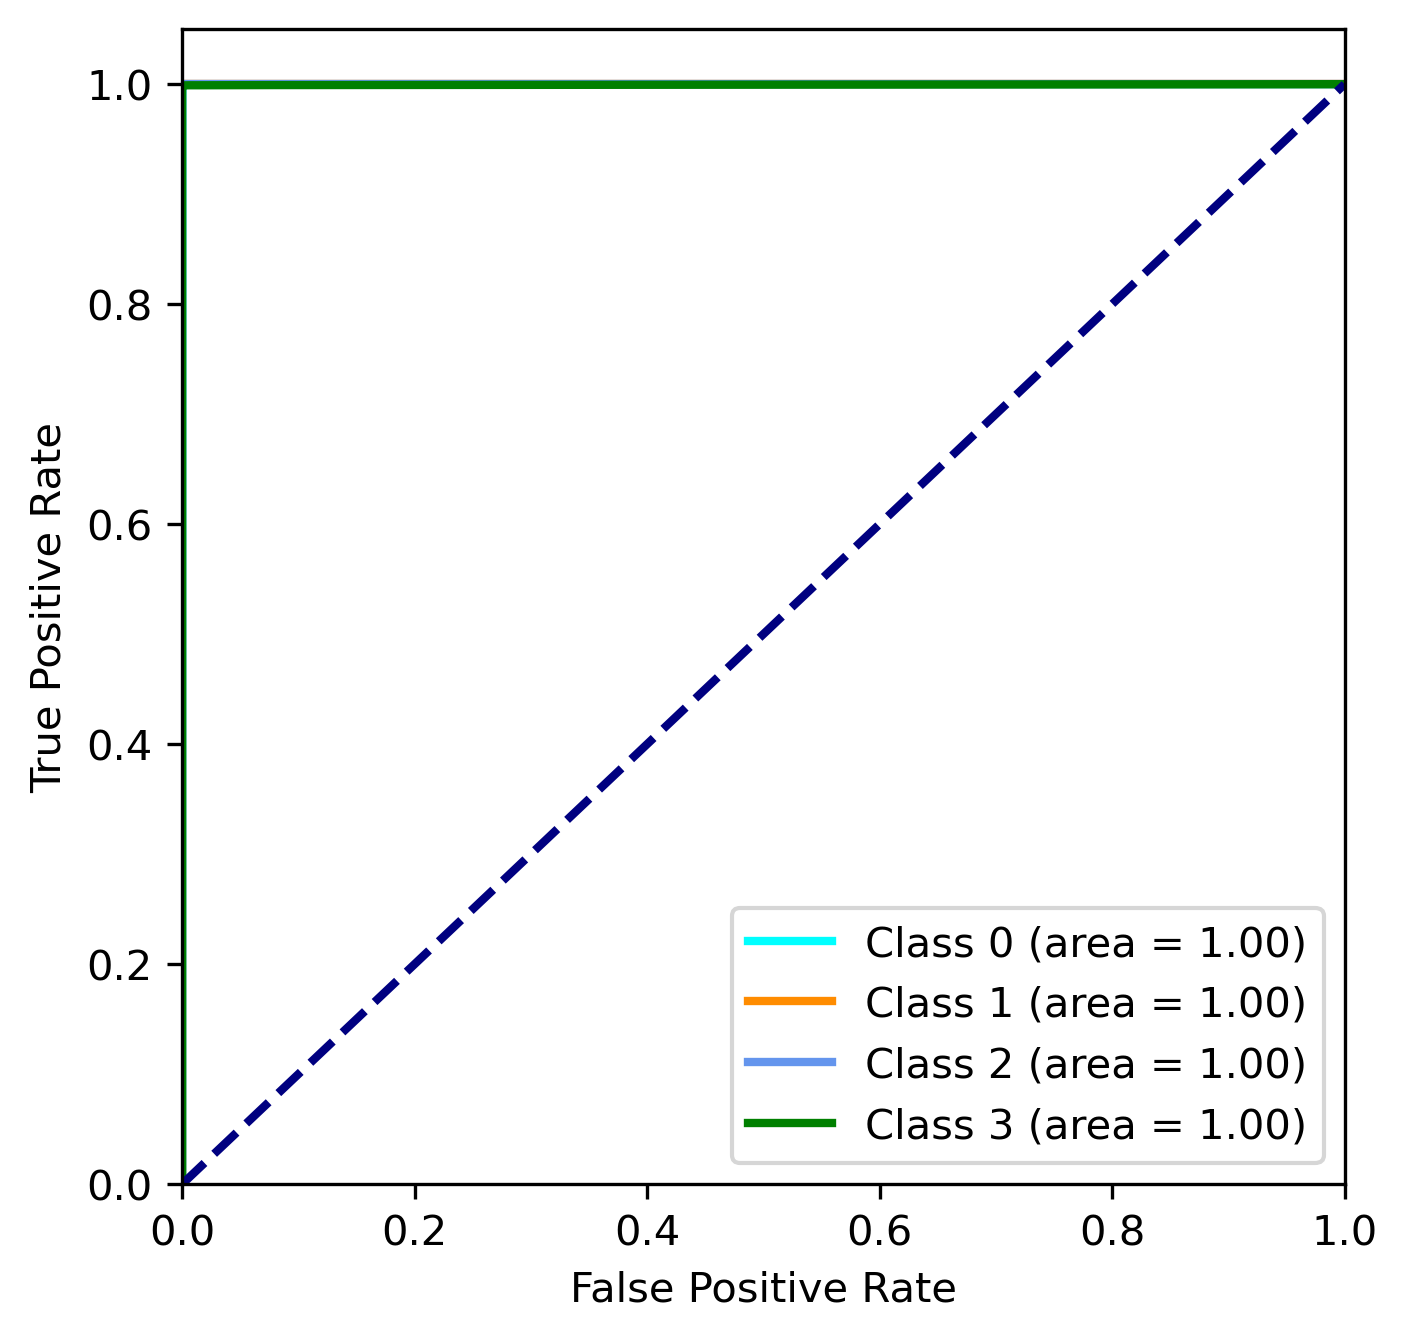

In [ ]:
# Binarize the output labels for ROC curve plotting
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Get the probabilities for each class
dtProba = rfc.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], dtProba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(5,5),dpi=300)
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pickle

# Save the model to a file
with open('random_forest_model_100.pkl', 'wb') as file:
    pickle.dump(rfc, file)

print("Model saved using pickle.")

Model saved using pickle.


In [ ]:
from joblib import dump

# Save the model to a file
dump(rfc, 'random_forest_model_100.joblib')

print("Model saved using joblib.")


Model saved using joblib.


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris

# Train Lasso model
lasso = LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto')
lasso.fit(features, target)

# Use SelectFromModel to select features with non-zero coefficients
sfm = SelectFromModel(lasso)
sfm.fit(features, target)





C:\Users\knowl\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\knowl\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


NameError: name 'X' is not defined

In [ ]:
# Get selected features
selected_features = sfm.transform(features)

In [ ]:
import pickle

# Save the model to a file
with open('lasso.pkl', 'wb') as file:
    pickle.dump(lasso, file)

print("Model saved using pickle.")


from joblib import dump

# Save the model to a file
dump(lasso, 'lasso.joblib')

print("Model saved using joblib.")


Model saved using pickle.
Model saved using joblib.


In [ ]:
import pickle

# Save the model to a file
with open('sfm.pkl', 'wb') as file:
    pickle.dump(sfm, file)

print("Model saved using pickle.")


from joblib import dump

# Save the model to a file
dump(sfm, 'sfm.joblib')

print("Model saved using joblib.")

Model saved using pickle.
Model saved using joblib.


In [ ]:
# Splitting dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(selected_features, target, test_size=0.25, shuffle=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
print("RF")
rfc = RandomForestClassifier(n_estimators=300, random_state=5, max_depth=300)  
rfc.fit(X_train, y_train)
# calculate accuracy of class predictions
y_pred_class = rfc.predict(X_test)
print(classification_report(y_test,y_pred_class))
print(confusion_matrix(y_test,y_pred_class))


RF
              precision    recall  f1-score   support

       IoT.B       1.00      1.00      1.00     25174
       IoT.M       1.00      1.00      1.00     24900
        Tr.B       1.00      1.00      1.00     24867
        Tr.M       1.00      1.00      1.00     25059

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000

[[25169     0     1     4]
 [    0 24900     0     0]
 [    0     0 24867     0]
 [   38     0     0 25021]]


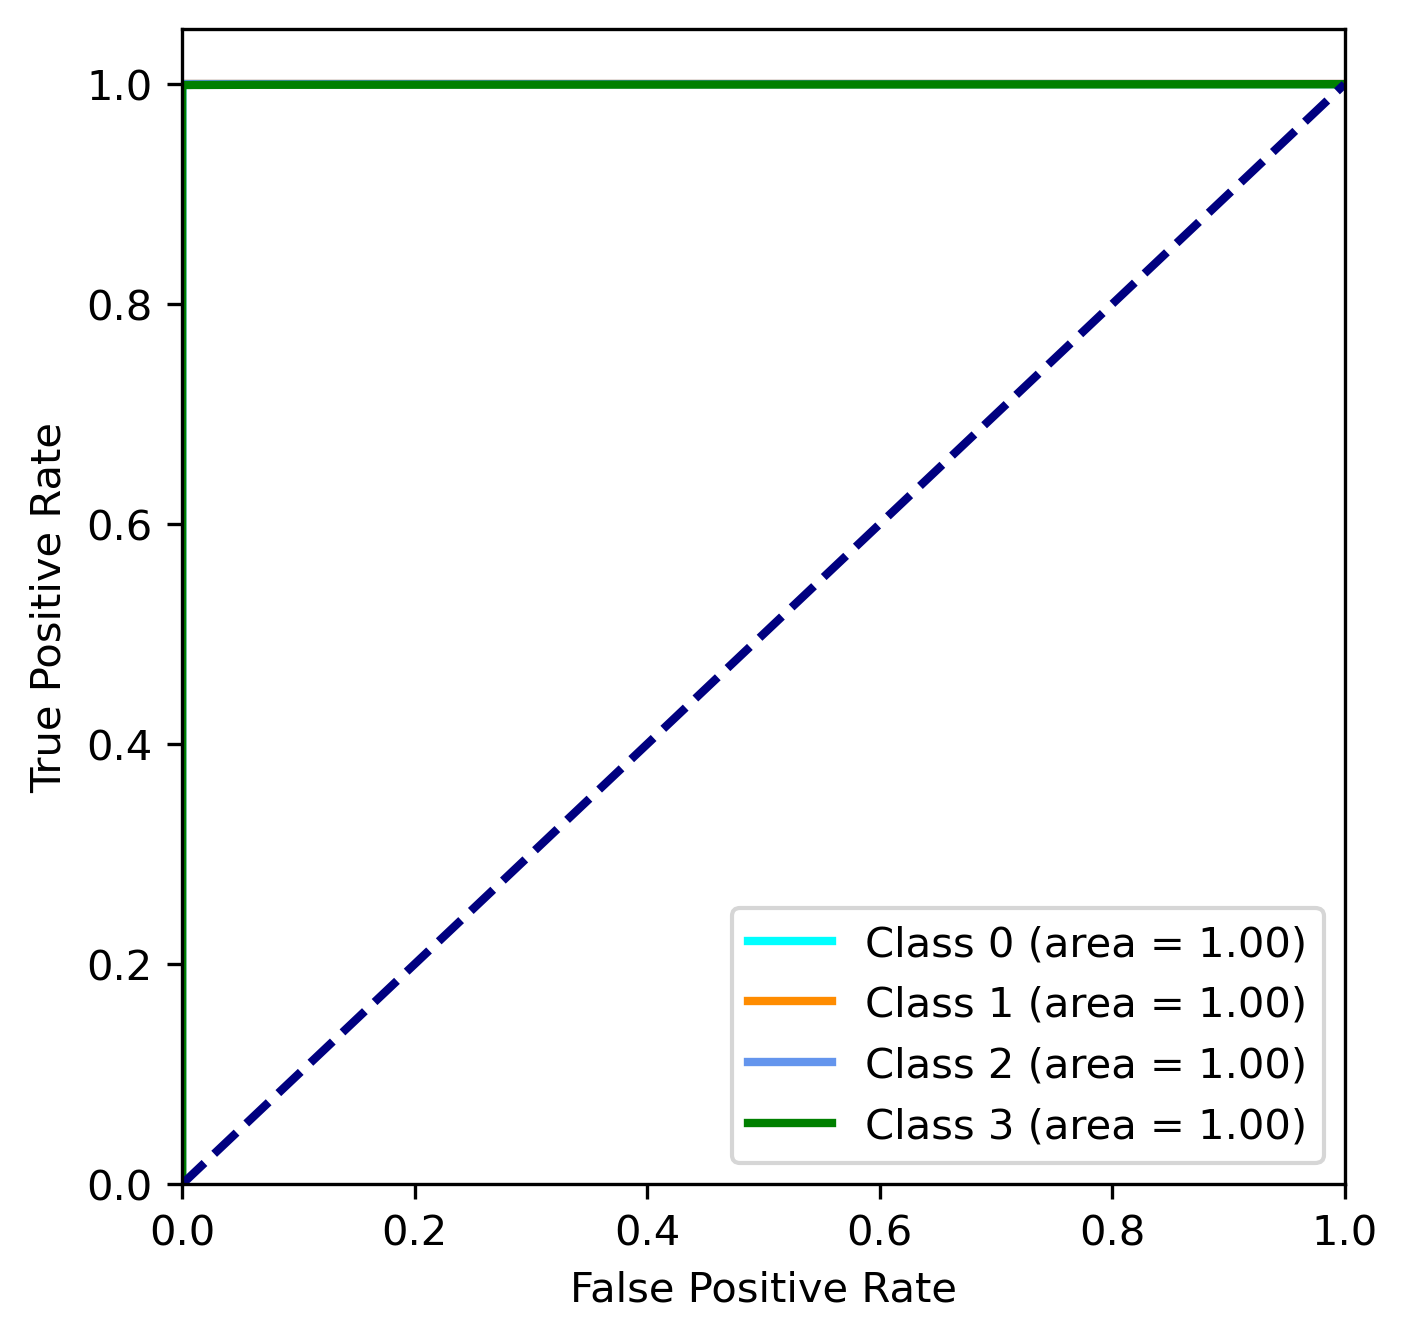

In [ ]:
# Binarize the output labels for ROC curve plotting
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Get the probabilities for each class
dtProba = rfc.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], dtProba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(5,5),dpi=300)
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pickle

# Save the model to a file
with open('random_forest_model_100_fE.pkl', 'wb') as file:
    pickle.dump(rfc, file)

print("Model saved using pickle.")

Model saved using pickle.


In [ ]:
from joblib import dump

# Save the model to a file
dump(rfc, 'random_forest_model_100_fE.joblib')

print("Model saved using joblib.")


Model saved using joblib.


In [ ]:
with open('random_forest_model.pkl', 'rb') as file:
    loaded_rfc_pickle = pickle.load(file)

# Now you can use loaded_rfc_pickle to make predictions or further analysis


In [ ]:
from joblib import load

loaded_rfc_joblib = load('random_forest_model.joblib')

# Now you can use loaded_rfc_joblib to make predictions or further analysis


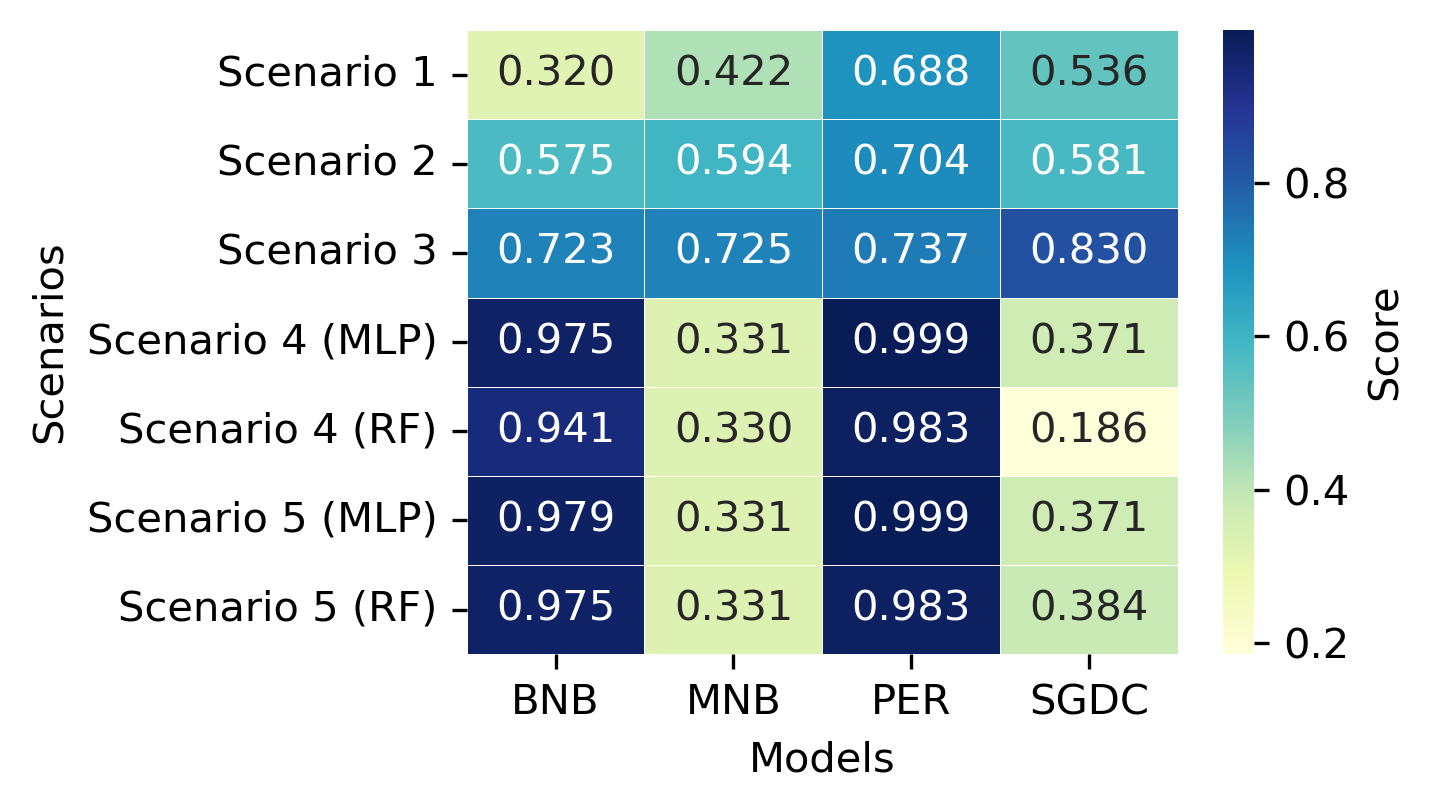

In [80]:
# Re-import required libraries after code execution state reset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Recreate the data from the heatmap
data = np.array([
    [0.320, 0.422, 0.688, 0.536],
    [0.575, 0.594, 0.704, 0.581],
    [0.723, 0.725, 0.737, 0.830],
    [0.975, 0.331, 0.999, 0.371],
    [0.941, 0.330, 0.983, 0.186],
    [0.979, 0.331, 0.999, 0.371],
    [0.975, 0.331, 0.983, 0.384],
])

models = ['BNB', 'MNB', 'PER', 'SGDC']
scenarios = [
    'Scenario 1',
    'Scenario 2',
    'Scenario 3',
    'Scenario 4 (MLP)',
    'Scenario 4 (RF)',
    'Scenario 5 (MLP)',
    'Scenario 5 (RF)'
]

df_heatmap = pd.DataFrame(data, index=scenarios, columns=models)

# Plot heatmap
plt.figure(figsize=(4.5, 2.5),dpi=300)
sns.heatmap(df_heatmap, annot=True, fmt=".3f", cmap="YlGnBu", linewidths=0.2, cbar_kws={"label": "Score"})
plt.xlabel("Models")
plt.ylabel("Scenarios")
plt.tight_layout(pad=0)
plt.savefig('fig8.jpg')
